In [1]:
import numpy as _np
import random as _rn
from joblib import Parallel as _Parallel
from joblib import delayed as _delayed
from joblib import effective_n_jobs as _effective_n_jobs

In [2]:
def _get_anom_score(xin, ntrees, c_fac, trees):
    S = _np.zeros(len(xin))
    for i in range(len(xin)):
        h_temp = 0
        for j in range(ntrees):
            h_temp += PathFactor(xin[i], trees[j]).path * 1.0
        Eh = h_temp / ntrees
        S[i] = 2.0**(-Eh / c_fac)
    return S


def _create_tree(x, ntrees, sample_size, limit, extlevel):
    return [iTree(x[_rn.sample(range(len(x)), sample_size)], 0,
            limit, extlevel) for _ in range(ntrees)]


def _split_n(x, k):
    y = [x // k for i in range(k)]
    for i in range(x % k):
        y[i] += 1
    return y


def c_factor(n):
    """ Average path length of unsuccesful search in a binary search tree
    given n points
    Parameters
    ----------
    n : int
        Number of data points for the BST.
    Returns
    -------
    float
        Average path length of unsuccesful search in a BST
    """
    return 2.0 * (_np.log(n - 1) + 0.5772156649) - (2.0 * (n - 1.) / (n * 1.0))


In [3]:
class iForest(object):
    """ Creates an iForest object. This object holds the data as well as the
    trained trees (iTree objects).
    Attributes
    ----------
    X : list
        Data used for training. It is a list of list of floats.
    nobjs: int
        Size of the dataset.
    sample: int
        Size of the sample to be used for tree creation.
    Trees: list
        A list of tree objects.
    limit: int
        Maximum depth a tree can have.
    exlevel: int
        Exention level to be used in the creating splitting critera.
    c: float
        Multiplicative factor used in computing the anomaly scores.
    Methods
    -------
    _checkExtensionLevel()
    Chaeck the validity of extension level provided by user based on the
    data
    compute_paths(X_in)
    Computes the anomaly score for data X_in
    """

    def __init__(self, X, ntrees, sample_size, limit=None, ExtensionLevel=0,
                 seed=None, n_jobs=1):
        """ iForest(X, ntrees,  sample_size, limit=None, ExtensionLevel=0)
        Initialize a forest by passing in training data, number of trees to be
        used and the subsample size.
        Parameters
        ----------
        X : list of list of floats
        Training data. List of [x1,x2,...,xn] coordinate points.
        ntrees : int
        Number of trees to be used.
        sample_size : int
        The size of the subsample to be used in creation of each tree.
        Must be smaller than |X|.
        limit : int
        The maximum allowed tree depth. This is by default set to average
        length of unsucessful search in a binary tree.
        ExtensionLevel : int
        Specifies degree of freedom in choosing the hyperplanes for
        dividing up data. Must be smaller than the dimension n of the
        dataset.
        """
        self.ntrees = ntrees
        self.X = X
        self.nobjs = len(X)
        self.sample = sample_size
        self.limit = limit
        self.exlevel = ExtensionLevel
        # Extension Level check. See def for explanation.
        self._checkExtensionLevel()
        if limit is None:
            # Set limit to the default as specified by the paper (average depth
            # of unsuccesful search through a binary tree).
            self.limit = int(_np.ceil(_np.log2(self.sample)))
        self.c = c_factor(self.sample)
        # This loop builds an ensemble of iTrees (the forest).
        sp = _split_n(ntrees, _effective_n_jobs(n_jobs))
        _rn.seed(seed)
        _np.random.seed(seed)
        tr = _Parallel(backend='multiprocessing', n_jobs=n_jobs)(
            _delayed(_create_tree)(X, sp[i], self.sample, self.limit,
                                   self.exlevel)
            for i in range(len(sp)))
        self.Trees = [j for i in tr for j in i]

    def __repr__(self):
        s = '{} Object:\n {{ntrees: {}, sample: {}, Max.Depth: {}, ' +\
            'exlevel: {}}}\n Observations: X({}) with shape {}:\n{}'
        return(s.format(type(self).__name__, self.ntrees, self.sample,
                        self.limit, self.exlevel, type(self.X).__name__,
                        self.X.shape, self.X))

    def _checkExtensionLevel(self):
        """ This function makes sure the extension level provided by the user
        does not exceed the dimension of the data. An exception will be raised
        in the case of a violation. """
        dim = self.X.shape[1]
        if self.exlevel < 0:
            raise Exception(
                "Extension level has to be an integer between 0 and " +
                str(dim - 1) + ".")
        if self.exlevel > dim - 1:
            raise Exception("Your data has " + str(dim) + " dimensions." +
                            " Extension level can't be higher than " +
                            str(dim - 1) + ".")

    def compute_paths(self, X_in=None, n_jobs=1):
        """
        compute_paths(X_in = None)
        Compute anomaly scores for all data points in a dataset X_in
        Parameters ---------- X_in : list of list of floats Data to be scored.
        iForest.Trees are used for computing the depth reached in each tree by
        each data point.
        Returns
        -------
        float
            Anomaly score for a given data point.
        """
        if X_in is None:
            X_in = self.X
        sp = _np.array_split(X_in, _effective_n_jobs(n_jobs))
        S = _Parallel(backend='multiprocessing', n_jobs=n_jobs)(
            _delayed(_get_anom_score)(sp[i], self.ntrees, self.c, self.Trees)
            for i in range(len(sp)))
        return _np.array([j for i in S for j in i])


In [4]:
class Node(object):
    """ A single node from each tree (each iTree object). Nodes containe
    information on hyperplanes used for data division, date to be passed to
    left and right nodes, whether they are external or internal nodes.
    Attributes
    ----------
    e: int
        Depth of the tree to which the node belongs.
    size: int
        Size of the dataset present at the node.
    X: list
        Data at the node.
    n: list
        Normal vector used to build the hyperplane that splits the data in
        the node.
    p: list
        Intercept point through which the hyperplane passes.
    lef: Node object
        Left child node.
    right: Node object
        Right child node.
    ntype: str
        The type of the node: 'exNode', 'inNode'.
    """

    def __init__(self, X, n, p, e, left, right, node_type=''):
        """
        Node(X, n, p, e, left, right, node_type = '' )
        Create a node in a given tree (iTree objectg)
        Parameters
        ----------
        X : list of list of floats
            Training data available to each node. List of [x1,x2,...,xn]
            coordinate points.
        n : list of floats
            Normal vector for the hyperplane used for splitting data.
        p : list of floats
            Intercept point for the hyperplane used for splitting data.
        left : Node object
            Left child node.
        right : Node object
            Right child node.
        node_type : str
            Specifies if the node is external or internal. Takes two values:
            'exNode', 'inNode'.
        """
        self.e = e
        self.size = len(X)
        self.X = X  # to be removed
        self.n = n
        self.p = p
        self.left = left
        self.right = right
        self.ntype = node_type

    def __repr__(self):
        def a2s(x):
            fmt = {'float_kind': lambda y: "% 4.5f" % y}
            return(_np.array2string(x, max_line_width=60, separator=',',
                                    threshold=6, formatter=fmt))
        s = '{} Object: {{node_type: {}, Depth(e): {}}}\n' +\
            '  Norm.Vec.(n): {}\n' +\
            '  Intercept(p): {}\n' +\
            '  Left :{:5d}\n' +\
            '  Right:{:5d}\n{} obs. of X: \n{}'
        left_size = 0 if self.left is None else self.left.size
        right_size = 0 if self.right is None else self.right.size
        return(s.format(type(self).__name__, self.ntype, self.e, a2s(self.n),
                        a2s(self.p), left_size, right_size, self.size,
                        a2s(self.X)))

In [12]:
class iTree(object):

    """
    A single tree in the forest that is build using a unique subsample.
    Attributes
    ----------
    exlevel: int
        Extension level used in the splitting criteria.
    e: int
        Depth of tree
    X: list
        Data present at the root node of this tree.
    size: int
        Size of the dataset.
    dim: int
        Dimension of the dataset.
    Q: list
        List of ordered integers smaller than dim.
    l: int
        Maxium depth a tree can reach before its creation is terminated.
    n: list
        Normal vector at the root of this tree, which is used in creating
        hyperplanes for splitting critera
    p: list
        Intercept point at the root of this tree through which the splitting
        hyperplane passes.
    exnodes: int
        The number of external nodes this tree has.
    root: Node object
        At each node create a new tree.
    Methods
    -------
    make_tree(X, e, l)
        Builds the tree recursively from a given node. Returns a Node object.
    """

    def __init__(self, X, e, l, exlevel=0):
        """
        iTree(X, e, l, exlevel=0)
        Create a tree
        Parameters
        ----------
        X : list of list of floats
            Subsample of training data. |X| = iForest.sample_size. List of
            [x1,x2,...,xn] coordinate points
        e : int
            Depth of the tree as it is being traversed down. e <= l.
        l : int
            The maximum depth the tree can reach before its creation is
            terminated.
        exlevel : int
            Specifies degree of freedom in choosing the hyperplanes for
            dividing up data. Must be smaller than the dimension n of the
            dataset.
        """
        self.exlevel = exlevel
        self.e = e
        self.X = X  # save data for now. Not really necessary.
        self.size = len(X)
        self.dim = self.X.shape[1]
        # n dimensions
        self.Q = _np.arange(_np.shape(X)[1], dtype='int')
        self.l = l
        # Intercept for the hyperplane for splitting data at a given node.
        self.p = None
        # Normal vector for the hyperplane for splitting data at a given node.
        self.n = None
        self.exnodes = 0
        self.innodes = 0
        # At each node create a new tree, starting with root node.
        self.root = self.make_tree(X, e, l)

    def __repr__(self):
        s = '{} Object: {{Depth(e): {}/{}, exlevel: {}, inNodes={}, ' +\
            'exNodes={}}}\n'
        return(s.format(type(self).__name__, self.e, self.l,
                        self.exlevel, self.innodes, self.exnodes))

    def make_tree(self, X, e, l):
        """
        make_tree(X,e,l)
        Builds the tree recursively from a given node. Returns a Node object.
        Parameters
        ----------
        X: list of list of floats
            Subsample of training data. |X| = iForest.sample_size. List of
            [x1,x2,...,xn] coordinate point.
        e : int
            Depth of the tree as it is being traversed down. Integer. e <= l.
        l : int
            The maximum depth the tree can reach before its creation is
            terminated. Integer.
        Returns
        -------
        Node object
        """
        self.e = e
        # A point is isolated in traning data, or the depth limit has been
        # reached.
        if e >= l or len(X) <= 1:
            left = None
            right = None
            self.exnodes += 1
            return Node(X, self.n, self.p, e, left, right, node_type='exNode')
        # Building the tree continues. All these nodes are internal.
        else:
            self.innodes += 1
            mins = X.min(axis=0)
            maxs = X.max(axis=0)
            # Pick the indices for which the normal vector elements should be
            # set to zero acccording to the extension level.
            idxs = _np.random.choice(
                range(self.dim), self.dim - self.exlevel - 1, replace=False)
            # A random normal vector picked form a uniform n-sphere. Note that
            # in order to pick uniformly from n-sphere, we need to pick a
            # random normal for each component of this vector.---------------------
            self.n = _np.random.normal(0, 1, self.dim)
            self.n[idxs] = 0
            # Picking a random intercept point for the hyperplane splitting
            # data.
            self.p = _np.random.uniform(mins, maxs)
            # Criteria that determines if a data point should go to the left or
            # right child node.
            w = (X - self.p).dot(self.n) < 0
            return Node(X, self.n, self.p, e,
                        left=self.make_tree(X[w], e + 1, l),
                        right=self.make_tree(X[~w], e + 1, l),
                        node_type='inNode')

In [13]:
class PathFactor(object):
    """ Given a single tree (iTree objext) and a data point x = [x1,x2,...,xn],
    compute the legth of the path traversed by the point on the tree when it
    reaches an external node.
    Attributes
    ----------
    path_list: list
        A list of strings 'L' or 'R' which traces the path a data point travels
        down a tree.
    x: list
        A single data point, which is represented as a list of floats.
    e: int
        The depth of a given node in the tree.
    Methods
    -------
    find_path(T)
        Given a tree, it finds the path a single data points takes.
    """

    def __init__(self, x, itree):
        """ PathFactor(x, itree)
        Given a single tree (iTree objext) and a data point x = [x1,x2,...,xn],
        compute the legth of the path traversed by the point on the tree when
        it reaches an external node.
        Parameters
        ----------
        x : list of floats
            A data point x = [x1, x2, ..., xn].
        itree : iTree object
            A single tree.
        """
        self.path_list = []
        self.x = x
        self.e = 0
        self.path = self.find_path(itree.root)

    def find_path(self, T):
        """ find_path(T)
        Given a tree, find the path for a single data point based on the
        splitting criteria stored at each node.
        Parameters
        ----------
        T : iTree object
        Returns
        -------
        int : The depth reached by the data point.
        """
        if T.ntype == 'exNode':
            if T.size <= 1:
                return self.e
            else:
                self.e += c_factor(T.size)
                return self.e
        else:
            # Intercept for the hyperplane for splitting data at a given node.
            p = T.p
            # Normal vector for the hyperplane for splitting data at a given
            # node.
            n = T.n

            self.e += 1

            if (self.x - p).dot(n) < 0:
                self.path_list.append('L')
                return self.find_path(T.left)
            else:
                self.path_list.append('R')
                return self.find_path(T.right)


def all_branches(node, current=[], branches=None):
    """ Utility function used in generating a graph visualization. It returns
    all the branches of a given tree so they can be visualized.
    Parameters
    ----------
    node: Node object
    Returns
    -------
    list : list of branches that were reached.
    """
    current = current[:node.e]
    if branches is None:
        branches = []
    if node.ntype == 'inNode':
        current.append('L')
        all_branches(node.left, current=current, branches=branches)
        current = current[:-1]
        current.append('R')
        all_branches(node.right, current=current, branches=branches)
    else:
        branches.append(current)
    return branches

In [7]:
import numpy as np
import pandas as pd
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix,auc,roc_auc_score
from sklearn.metrics import recall_score,precision_score,accuracy_score,f1_score,matthews_corrcoef
#Data Handling: Load dataset (CSV file)
df = pd.read_csv("creditcard.csv")

In [8]:
fraud = df[df['Class'] == 1] # Number of fraudulent transactions
valid = df[df['Class'] == 0] # Number of valid transactions
anomalies_ratio = len(fraud)/float(len(valid))
print(anomalies_ratio)

0.0017304750013189597


In [10]:
X = df.drop(['Class'],axis=1) # X is input
y = df['Class'] # y is output
print(X.shape)
print(y.shape)
X_data = X.values
y_data = y.values

(284807, 30)
(284807,)


In [15]:
from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, random_state = 42)
eif = iForest(X_data,100,len(X_data),0)
score = eif.compute_paths(X_data)
score_sorted = np.argsort(score)
ind_with_pred = score_sorted[-int(np.ceil(0.009 * X.shape[0])):]
#print(ind_with_pred)
y_pred = np.zeros_like(y)
y_pred[ind_with_pred] = 1
#y_pred[y_pred == 1] = 0
#y_pred[y_pred == -1] = 1
conf_matrix = confusion_matrix(y, y_pred)
print(conf_matrix)

[[281756   2559]
 [   487      5]]


In [21]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(y_pred.shape)

(227845, 30)
(227845,)
(56962, 30)
(56962,)
(227845,)


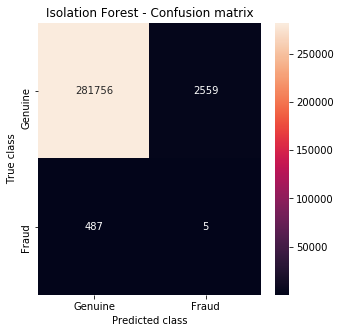

In [16]:
#printing the confusion matrix
LABELS = ['Genuine', 'Fraud']
conf_matrix = confusion_matrix(y, y_pred)
#print(conf_matrix)
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt='d');
plt.title('Isolation Forest - Confusion matrix')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [13]:
print('Isolation Forest')
acc= accuracy_score(y_data,y_pred)
print('Accuracy : {}'.format(acc))
prec= precision_score(y_data,y_pred)
print('Precision : {}'.format(prec))
rec= recall_score(y_data,y_pred)
print('Recall : {}'.format(rec))
f1= f1_score(y_data,y_pred)
print('F1-Score : {}'.format(f1))
mcc = matthews_corrcoef(y_data,y_pred)
print('MCC : {}'.format(mcc))

Isolation Forest
Accuracy : 0.9965415175891043
Precision : 0.0
Recall : 0.0
F1-Score : 0.0
MCC : -0.0017322357677627754
